## SVD 
---
Surprise algorithm: SVD(biased=False, n_epochs = 100)

Hyperparameter: 
1. Threshold when do the recommendation

Things to do:
1. Calculate test loss
2. Do the recommendations (done)
3. Calculate precision, recall

In [1]:
import random
import pandas as pd
import json
import numpy as np
import scipy.sparse as sp
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import rc
rc('figure', figsize=(16, 8), max_open_warning=False)

from surprise import SVD
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split

import sys
sys.path.insert(0, '../src')

import preprocess
import evaluation

In [2]:
random_dict = preprocess.create_random_subset_paper_paper_data(debug=True)
data = preprocess.create_surprise_paper_paper_data(random_dict)

In [3]:
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(biased=False, n_epochs = 100)
algo.fit(trainset)
predictions = algo.test(testset, clip=False)
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])

In [4]:
df[df.details == {'was_impossible': False}][1:10]

,uid,iid,rui,est,details
28,56182f0c-b75a-48ef-b804-0a4f261e6e63,d58e8c74-17ad-4ec0-8ab1-732509c1dd45,1.0,0.243732,{'was_impossible': False}
36,3dc62931-dc97-42e3-b049-377f62a9be91,ccd672d4-2f77-471e-abfc-cae8abd6ec16,1.0,-1.167404,{'was_impossible': False}
52,d2b61e9a-31cc-4df4-8893-dce67e1383a1,e32cafab-3b60-4d54-9858-ef499286cdf2,1.0,-1.013322,{'was_impossible': False}
64,984c8b7f-ae7e-4b9f-95bd-164e2651a3db,700c7b6c-eaf8-4b40-b969-645109cda205,1.0,-0.917862,{'was_impossible': False}
89,2ced1d5a-a5ff-4860-99d2-9832b11b1f40,978efa8a-b62a-4e76-a2a1-c3a7af5e1a60,1.0,-1.069874,{'was_impossible': False}
95,1a854ef8-d062-4d04-8a6d-2b9bb403c86e,ed46c437-47c2-4767-8d60-fb58fdc47733,1.0,-0.547996,{'was_impossible': False}
102,16b0076d-f64c-40c8-a974-94df1e9c795b,9c5362e9-1ab3-4bbd-bca4-7b13053cdd31,1.0,-0.768732,{'was_impossible': False}
106,56182f0c-b75a-48ef-b804-0a4f261e6e63,5e7b1c2c-baaf-466d-be01-c075002bf1fb,1.0,-0.249297,{'was_impossible': False}
118,c0b5c6d8-a1bf-4607-bdfd-c02569f52824,6ef6bd3b-2c16-4ec6-8909-1840d12b320c,1.0,-0.969236,{'was_impossible': False}


### Comments - 
All the estimate value are negative in the above table while they should be close to 1.

In [5]:
# Visualize train set data
usernum = trainset.n_users
itemnum = trainset.n_items

papermat = sp.dok_matrix((usernum,itemnum), dtype=np.int8)
for i in range(trainset.n_users):
    for paper_id in trainset.ur[i]:
        papermat[i, paper_id[0]] = 1

In [6]:
# Visualize test set data
for j in range(len(testset)):
    uid    = testset[j][0]
    iid    = testset[j][1]
    rating = testset[j][2]
    try:
        iuid = algo.trainset.to_inner_uid(uid)
    except:
        continue
    try:
        iiid = algo.trainset.to_inner_iid(iid)
    except:
        continue
#     print(iuid, iiid)
    papermat[iuid, iiid] = -1

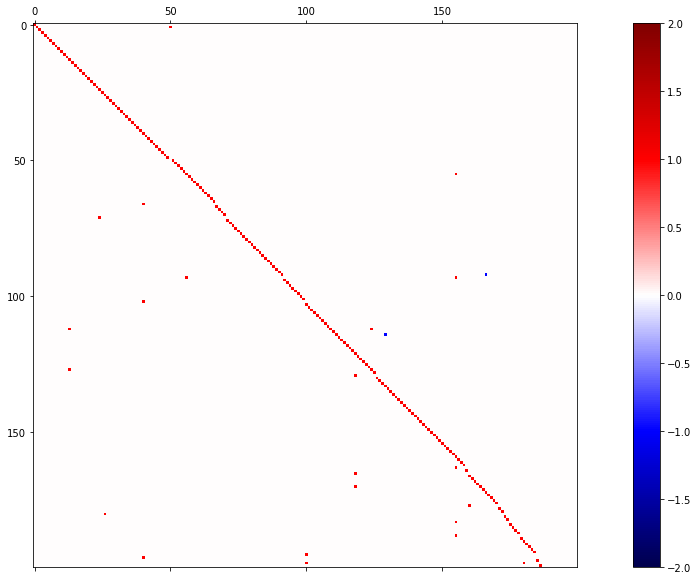

In [7]:
A = papermat.todense()
fig, axes = plt.subplots(figsize=(20, 10))
pos = axes.matshow(A[0:200,0:200], cmap='seismic',vmin=-2., vmax=2.)
fig.colorbar(pos)

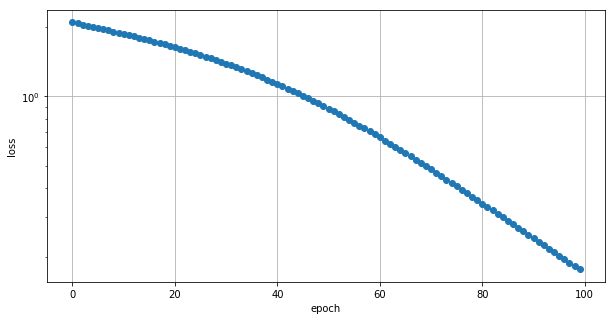

In [8]:
# Comment out following code if not using --
#  https://github.com/MelodyShih/Surprise/tree/1003-project
loss = algo.losshistory
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(range(len(loss)), loss, '--o')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.grid(True)

In [9]:
# Only work for SVD with biased = False
pu = algo.pu
qi = algo.qi

Abar = np.dot(pu, np.transpose(qi))
print(Abar.shape)
Abar = Abar - np.ones(Abar.shape)

(2583, 2338)


3430


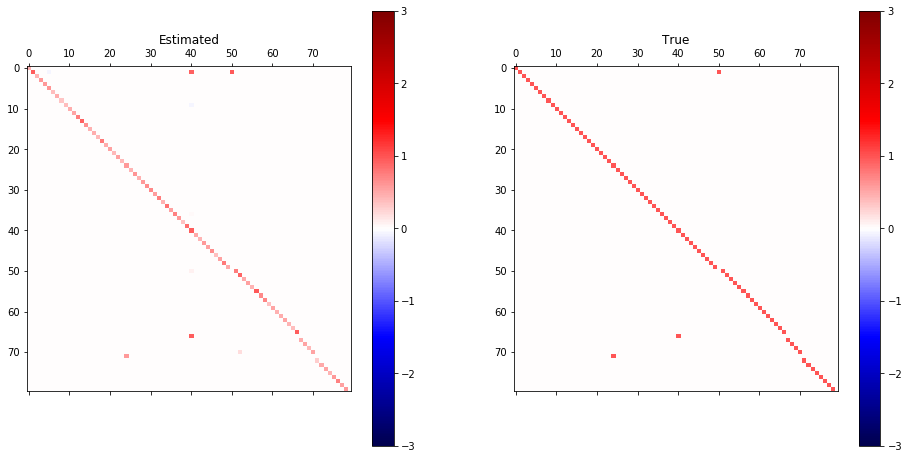

In [10]:
fig, axes = plt.subplots(1, 2)
threshold = -0.1
mask = Abar[0:80, 0:80] >= threshold
print(sum(sum(Abar >= threshold)))
pos = axes[0].matshow(Abar[0:80,0:80]*mask , cmap='seismic',vmin=-3, vmax=3.)
axes[0].set_title('Estimated')
fig.colorbar(pos, ax=axes[0])

pos = axes[1].matshow(A[0:80, 0:80] , cmap='seismic',vmin=-3, vmax=3.)
axes[1].set_title('True')
fig.colorbar(pos, ax=axes[1])

### Comments - 
From loss and the above graph, SVD fits the training data well.

## Recommendation list

In [11]:
# this function can put in surprise
def build_data_for_prediction(self,user_ids):
    """Return a list of ratings that can be used as a testset in the
    :meth:`test() <surprise.prediction_algorithms.algo_base.AlgoBase.test>`
    method.
    """
    alldata = []
    for i in range(len(user_ids)):
        for j in range(self.n_items):
            alldata.append((self.to_raw_uid(i),self.to_raw_iid(j),0))
    return alldata

In [12]:
# build a list to do the recommendation for user_ids
user_ids = [0]
userdata = build_data_for_prediction(trainset, user_ids)

predictions = algo.test(userdata[0:len(user_ids)], clip=False)
rec_list = evaluation.get_items_greater_threshold(predictions, -0.1)

In [13]:
# list of papers that recommend to user_id = 0
rec_list

defaultdict(list,
            {'4d7e501c-a34b-403a-815b-e6226b4baa10': [('60c791c2-67de-43ec-b1da-05c28d4973e6',
               0.45131383379134338)]})